来试试用起点中文网的历史小说『寒门首辅（一袖乾坤 著）』来做训练数据，看看这个RNN网络能产生一些什么样子的文本。
尝试过程中必遇到问题，也借此加深一些对RNN的理解。

首先我从网上下载到了『寒门首辅』的txt版本，打开时候发现有很多空行，还包含了很多不必要的链接，看起来是这样的。

In [1]:
from IPython.display import Image

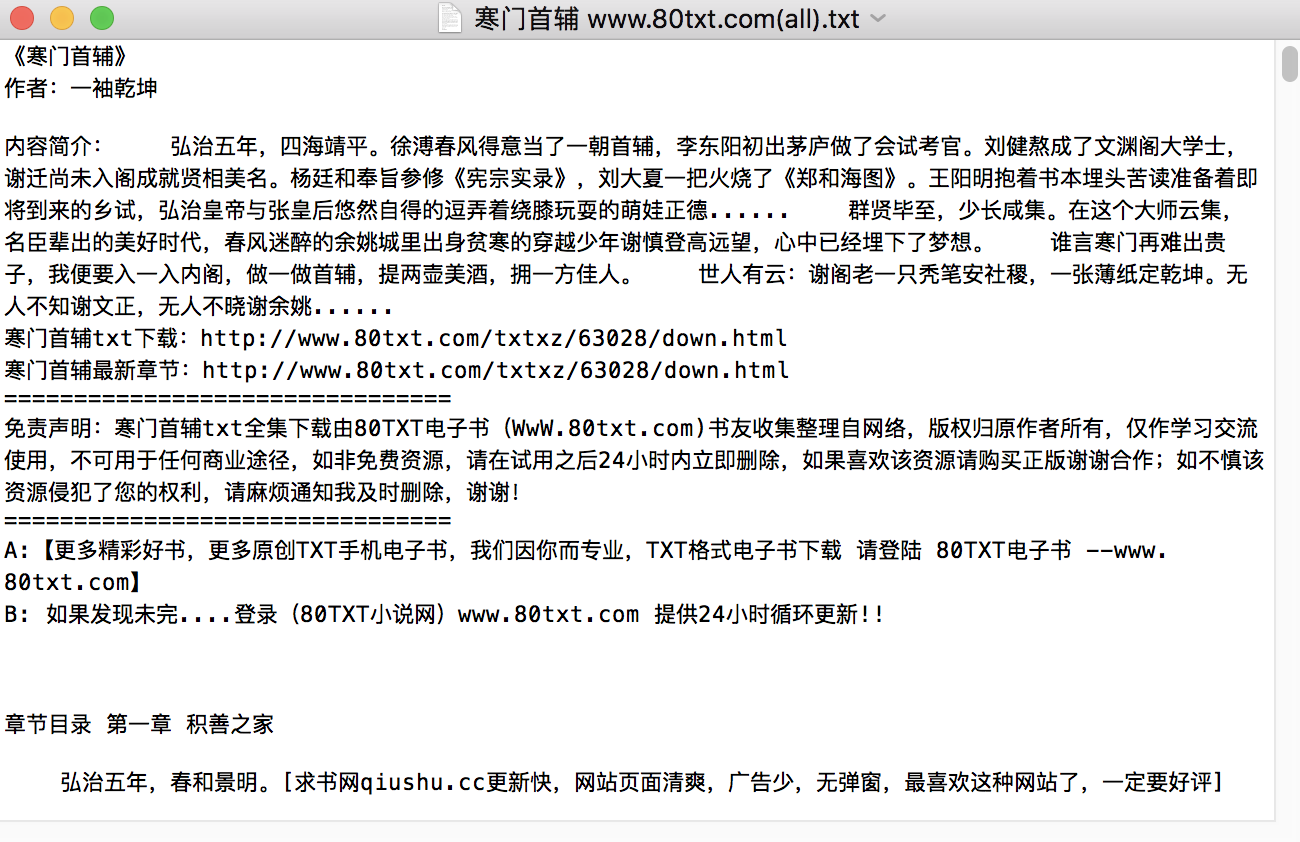

In [2]:
Image("img/raw_state.png")

这里有两个实验想做，第一是我把空格空行什么的都移除掉，只剩下文字全部连在一起的，这样训练完了，这个模型写出来的文本应该就没有像空行，缩进这样的格式；第二种就是保留章节之间的空行和段落的缩进，看看最后训练结果是否也能掌握书写格式的能力。

先完成第一个实验吧，就是产生不带格式的纯文字。

预处理一下数据。

In [3]:
import helper

读入数据

In [4]:
dir = './data/寒门首辅.txt'
text = helper.load_text(dir)

设置一下要用多少个字来训练，方便调试

In [5]:
num_words_for_training = 100000

text = text[:num_words_for_training]

看看有多少行

In [6]:
lines_of_text = text.split('\n')

print(len(lines_of_text))

4329


先看看前15行是什么内容

In [7]:
print(lines_of_text[:15])

['《寒门首辅》', '作者：一袖乾坤', '', '内容简介：    弘治五年，四海靖平。徐溥春风得意当了一朝首辅，李东阳初出茅庐做了会试考官。刘健熬成了文渊阁大学士，谢迁尚未入阁成就贤相美名。杨廷和奉旨参修《宪宗实录》，刘大夏一把火烧了《郑和海图》。王阳明抱着书本埋头苦读准备着即将到来的乡试，弘治皇帝与张皇后悠然自得的逗弄着绕膝玩耍的萌娃正德......    群贤毕至，少长咸集。在这个大师云集，名臣辈出的美好时代，春风迷醉的余姚城里出身贫寒的穿越少年谢慎登高远望，心中已经埋下了梦想。    谁言寒门再难出贵子，我便要入一入内阁，做一做首辅，提两壶美酒，拥一方佳人。    世人有云：谢阁老一只秃笔安社稷，一张薄纸定乾坤。无人不知谢文正，无人不晓谢余姚......  ', '寒门首辅txt下载：http://www.80txt.com/txtxz/63028/down.html', '寒门首辅最新章节：http://www.80txt.com/txtxz/63028/down.html', '================================', '免责声明：寒门首辅txt全集下载由80TXT电子书（WwW.80txt.com)书友收集整理自网络，版权归原作者所有，仅作学习交流使用，不可用于任何商业途径，如非免费资源，请在试用之后24小时内立即删除，如果喜欢该资源请购买正版谢谢合作；如不慎该资源侵犯了您的权利，请麻烦通知我及时删除，谢谢！', '================================', 'A:【更多精彩好书，更多原创TXT手机电子书，我们因你而专业，TXT格式电子书下载 请登陆 80TXT电子书 --www.80txt.com】', 'B: 如果发现未完....登录（80TXT小说网）www.80txt.com 提供24小时循环更新!!', '', '', '', '章节目录 第一章 积善之家']


把『章节目录』之前的行全部砍掉，一大堆没用的东西。

In [8]:
lines_of_text = lines_of_text[14:]

再来看看，第一行应该就进入正题了。

In [9]:
print(lines_of_text[:5])

['章节目录 第一章 积善之家', '', '    弘治五年，春和景明。[求书网qiushu.cc更新快，网站页面清爽，广告少，无弹窗，最喜欢这种网站了，一定要好评]', '', '    浙江承宣布政使司，绍兴府，余姚县。']


我查看了一下，这个小说一共有129万字左右。

先把空行去掉吧。去掉空行之后应该就只有一半左右的行数了。

In [10]:
lines_of_text = [lines for lines in lines_of_text if len(lines) > 0]

print(len(lines_of_text))

2158


打印前20行看看什么情况

In [11]:
print(lines_of_text[:20])

['章节目录 第一章 积善之家', '    弘治五年，春和景明。[求书网qiushu.cc更新快，网站页面清爽，广告少，无弹窗，最喜欢这种网站了，一定要好评]', '    浙江承宣布政使司，绍兴府，余姚县。', '    县城里靠近城隍庙的一处小巷口，一个年约十二，身着淡蓝色粗布长衫，头戴黑色幞头的少年望着不远处熙熙攘攘的人群不发一言。', '    他叫谢慎，是土生土长的余姚人。但是也不尽然，因为他的灵魂来自后世，是穿越而来夺舍附着在这个与他同名同姓的少年身上。事情的经过他并不是很清楚，只知道这个少年应该是不慎落水，被人救上后就一直昏迷不醒，奄奄一息，直到自己穿越才鸠占鹊巢，成了这具身体的主人。', '    不过有些奇特的是，谢慎还兼有原先身体里的一部分记忆，他拼命检索这才对身处的环境有了一个大概的认识。', '    如今是弘治五年，当今天子朱祐樘立志中兴，招贤纳士，敕令各省提学官巡视省内各府、州、县学，选拔参加乡试的人选。今年是乡试之年，明年则是会试，殿试连着两场大试，是出进士的年份。朝为田舍郎，暮登天子堂，在明朝读书自然是最有前途的事情。不过这似乎和他没有什么关系，虽然原先的谢慎也算是个读书人，可却并没有功名在身，最多只能算一个半吊子童生。', '    谢慎前世可是苦修明史的研究生，虽然主攻方向是嘉靖万历两朝，但对弘治朝多少也有些了解。浙江一直是科举强省，在弘治朝也是绝对的霸主，而绍兴府则是浙江省中出进士最多的府。mianhuatang.cc [棉花糖小说网]若要落在县一级，那魁首非余姚莫属。山阴，会稽两县加在一起，所中的进士数目都不比余姚的多。这么说来，余姚绝对是科举的死亡之组了。王阳明，谢迁，王华，一想到余姚出的那些名人，谢慎便免不了自嘲。', '    谢慎虽然前世苦修明史，对八股文也有所研究，但要让他在明代科场竞争最恐怖的余姚县脱颖而出，确实有些艰难。', '    可当他垂下头看了看自己瘦弱的身体，不免摇了摇头，长叹了一声。', '    不科举还能干什么呢，就他这副竹竿子般的身体，肩不能抗，手不能提，杀鸡没准还被鸡调戏......', '    何况在这个万般皆下品惟有读书高的年代，不科举就只能为民，不管是务农还是经商终归都是被官府压着，没有出头的机会。大明朝那个著名的沈万三不就是最好的例子，家财万贯富可敌国还不是随意一个罪名就成了别人茶

下一步，把每行里面的『空格』，『[]里的内容』，『<>里的内容』都去掉。

In [12]:
# 去掉每行首尾空格
lines_of_text = [lines.strip() for lines in lines_of_text]

看下情况如何，打印前20句话。

In [13]:
print(lines_of_text[:20])

['章节目录 第一章 积善之家', '弘治五年，春和景明。[求书网qiushu.cc更新快，网站页面清爽，广告少，无弹窗，最喜欢这种网站了，一定要好评]', '浙江承宣布政使司，绍兴府，余姚县。', '县城里靠近城隍庙的一处小巷口，一个年约十二，身着淡蓝色粗布长衫，头戴黑色幞头的少年望着不远处熙熙攘攘的人群不发一言。', '他叫谢慎，是土生土长的余姚人。但是也不尽然，因为他的灵魂来自后世，是穿越而来夺舍附着在这个与他同名同姓的少年身上。事情的经过他并不是很清楚，只知道这个少年应该是不慎落水，被人救上后就一直昏迷不醒，奄奄一息，直到自己穿越才鸠占鹊巢，成了这具身体的主人。', '不过有些奇特的是，谢慎还兼有原先身体里的一部分记忆，他拼命检索这才对身处的环境有了一个大概的认识。', '如今是弘治五年，当今天子朱祐樘立志中兴，招贤纳士，敕令各省提学官巡视省内各府、州、县学，选拔参加乡试的人选。今年是乡试之年，明年则是会试，殿试连着两场大试，是出进士的年份。朝为田舍郎，暮登天子堂，在明朝读书自然是最有前途的事情。不过这似乎和他没有什么关系，虽然原先的谢慎也算是个读书人，可却并没有功名在身，最多只能算一个半吊子童生。', '谢慎前世可是苦修明史的研究生，虽然主攻方向是嘉靖万历两朝，但对弘治朝多少也有些了解。浙江一直是科举强省，在弘治朝也是绝对的霸主，而绍兴府则是浙江省中出进士最多的府。mianhuatang.cc [棉花糖小说网]若要落在县一级，那魁首非余姚莫属。山阴，会稽两县加在一起，所中的进士数目都不比余姚的多。这么说来，余姚绝对是科举的死亡之组了。王阳明，谢迁，王华，一想到余姚出的那些名人，谢慎便免不了自嘲。', '谢慎虽然前世苦修明史，对八股文也有所研究，但要让他在明代科场竞争最恐怖的余姚县脱颖而出，确实有些艰难。', '可当他垂下头看了看自己瘦弱的身体，不免摇了摇头，长叹了一声。', '不科举还能干什么呢，就他这副竹竿子般的身体，肩不能抗，手不能提，杀鸡没准还被鸡调戏......', '何况在这个万般皆下品惟有读书高的年代，不科举就只能为民，不管是务农还是经商终归都是被官府压着，没有出头的机会。大明朝那个著名的沈万三不就是最好的例子，家财万贯富可敌国还不是随意一个罪名就成了别人茶余饭后唏嘘慨叹的谈资？', '读书，还是得读书，便前方是刀山火海硬着头皮也得上。他才十二

可以看到空格都没了。下一步用正则去掉『[]』和『<>』中的内容，像上面的什么『[棉花糖小说网]』这些的，后面还有一些是包含在『<>』里的，一并去掉。

In [14]:
import re

# 生成一个正则，负责找『[]』包含的内容
pattern = re.compile(r'\[.*\]')

# 将所有指定内容替换成空
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text]

打印看效果。

In [15]:
print(lines_of_text[:20])

['章节目录 第一章 积善之家', '弘治五年，春和景明。', '浙江承宣布政使司，绍兴府，余姚县。', '县城里靠近城隍庙的一处小巷口，一个年约十二，身着淡蓝色粗布长衫，头戴黑色幞头的少年望着不远处熙熙攘攘的人群不发一言。', '他叫谢慎，是土生土长的余姚人。但是也不尽然，因为他的灵魂来自后世，是穿越而来夺舍附着在这个与他同名同姓的少年身上。事情的经过他并不是很清楚，只知道这个少年应该是不慎落水，被人救上后就一直昏迷不醒，奄奄一息，直到自己穿越才鸠占鹊巢，成了这具身体的主人。', '不过有些奇特的是，谢慎还兼有原先身体里的一部分记忆，他拼命检索这才对身处的环境有了一个大概的认识。', '如今是弘治五年，当今天子朱祐樘立志中兴，招贤纳士，敕令各省提学官巡视省内各府、州、县学，选拔参加乡试的人选。今年是乡试之年，明年则是会试，殿试连着两场大试，是出进士的年份。朝为田舍郎，暮登天子堂，在明朝读书自然是最有前途的事情。不过这似乎和他没有什么关系，虽然原先的谢慎也算是个读书人，可却并没有功名在身，最多只能算一个半吊子童生。', '谢慎前世可是苦修明史的研究生，虽然主攻方向是嘉靖万历两朝，但对弘治朝多少也有些了解。浙江一直是科举强省，在弘治朝也是绝对的霸主，而绍兴府则是浙江省中出进士最多的府。mianhuatang.cc 若要落在县一级，那魁首非余姚莫属。山阴，会稽两县加在一起，所中的进士数目都不比余姚的多。这么说来，余姚绝对是科举的死亡之组了。王阳明，谢迁，王华，一想到余姚出的那些名人，谢慎便免不了自嘲。', '谢慎虽然前世苦修明史，对八股文也有所研究，但要让他在明代科场竞争最恐怖的余姚县脱颖而出，确实有些艰难。', '可当他垂下头看了看自己瘦弱的身体，不免摇了摇头，长叹了一声。', '不科举还能干什么呢，就他这副竹竿子般的身体，肩不能抗，手不能提，杀鸡没准还被鸡调戏......', '何况在这个万般皆下品惟有读书高的年代，不科举就只能为民，不管是务农还是经商终归都是被官府压着，没有出头的机会。大明朝那个著名的沈万三不就是最好的例子，家财万贯富可敌国还不是随意一个罪名就成了别人茶余饭后唏嘘慨叹的谈资？', '读书，还是得读书，便前方是刀山火海硬着头皮也得上。他才十二岁，还有可塑性......', '“小郎，你怎么在这儿呢，快快随我回家去。你落水后被救起身子本就虚弱，若是在此

『[]』的内容已经没了。下一步去掉『<>』中的内容，方法同上。

In [16]:
# 将上面的正则换成负责找『<>』包含的内容
pattern = re.compile(r'<.*>')

# 将所有指定内容替换成空
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text]

下一步，把每句话最后的『......』换成『。』。

In [17]:
# 将上面的正则换成负责找『......』包含的内容
pattern = re.compile(r'\.+')

# 将所有指定内容替换成空
lines_of_text = [pattern.sub("。", lines) for lines in lines_of_text]

打印看效果。

In [18]:
print(lines_of_text[:20])

['章节目录 第一章 积善之家', '弘治五年，春和景明。', '浙江承宣布政使司，绍兴府，余姚县。', '县城里靠近城隍庙的一处小巷口，一个年约十二，身着淡蓝色粗布长衫，头戴黑色幞头的少年望着不远处熙熙攘攘的人群不发一言。', '他叫谢慎，是土生土长的余姚人。但是也不尽然，因为他的灵魂来自后世，是穿越而来夺舍附着在这个与他同名同姓的少年身上。事情的经过他并不是很清楚，只知道这个少年应该是不慎落水，被人救上后就一直昏迷不醒，奄奄一息，直到自己穿越才鸠占鹊巢，成了这具身体的主人。', '不过有些奇特的是，谢慎还兼有原先身体里的一部分记忆，他拼命检索这才对身处的环境有了一个大概的认识。', '如今是弘治五年，当今天子朱祐樘立志中兴，招贤纳士，敕令各省提学官巡视省内各府、州、县学，选拔参加乡试的人选。今年是乡试之年，明年则是会试，殿试连着两场大试，是出进士的年份。朝为田舍郎，暮登天子堂，在明朝读书自然是最有前途的事情。不过这似乎和他没有什么关系，虽然原先的谢慎也算是个读书人，可却并没有功名在身，最多只能算一个半吊子童生。', '谢慎前世可是苦修明史的研究生，虽然主攻方向是嘉靖万历两朝，但对弘治朝多少也有些了解。浙江一直是科举强省，在弘治朝也是绝对的霸主，而绍兴府则是浙江省中出进士最多的府。mianhuatang。cc 若要落在县一级，那魁首非余姚莫属。山阴，会稽两县加在一起，所中的进士数目都不比余姚的多。这么说来，余姚绝对是科举的死亡之组了。王阳明，谢迁，王华，一想到余姚出的那些名人，谢慎便免不了自嘲。', '谢慎虽然前世苦修明史，对八股文也有所研究，但要让他在明代科场竞争最恐怖的余姚县脱颖而出，确实有些艰难。', '可当他垂下头看了看自己瘦弱的身体，不免摇了摇头，长叹了一声。', '不科举还能干什么呢，就他这副竹竿子般的身体，肩不能抗，手不能提，杀鸡没准还被鸡调戏。', '何况在这个万般皆下品惟有读书高的年代，不科举就只能为民，不管是务农还是经商终归都是被官府压着，没有出头的机会。大明朝那个著名的沈万三不就是最好的例子，家财万贯富可敌国还不是随意一个罪名就成了别人茶余饭后唏嘘慨叹的谈资？', '读书，还是得读书，便前方是刀山火海硬着头皮也得上。他才十二岁，还有可塑性。', '“小郎，你怎么在这儿呢，快快随我回家去。你落水后被救起身子本就虚弱，若是在此时再染上了风寒，那可

最后，还是把每句话里面包含的空格，都转换成『，』，就像『章节目录 第一章』，换成『章节目录，第一章』，感觉这一步可有可无了。

In [19]:
# 将上面的正则换成负责找行中的空格
pattern = re.compile(r' +')

# 将所有指定内容替换成空
lines_of_text = [pattern.sub("，", lines) for lines in lines_of_text]

print(lines_of_text[:20])

['章节目录，第一章，积善之家', '弘治五年，春和景明。', '浙江承宣布政使司，绍兴府，余姚县。', '县城里靠近城隍庙的一处小巷口，一个年约十二，身着淡蓝色粗布长衫，头戴黑色幞头的少年望着不远处熙熙攘攘的人群不发一言。', '他叫谢慎，是土生土长的余姚人。但是也不尽然，因为他的灵魂来自后世，是穿越而来夺舍附着在这个与他同名同姓的少年身上。事情的经过他并不是很清楚，只知道这个少年应该是不慎落水，被人救上后就一直昏迷不醒，奄奄一息，直到自己穿越才鸠占鹊巢，成了这具身体的主人。', '不过有些奇特的是，谢慎还兼有原先身体里的一部分记忆，他拼命检索这才对身处的环境有了一个大概的认识。', '如今是弘治五年，当今天子朱祐樘立志中兴，招贤纳士，敕令各省提学官巡视省内各府、州、县学，选拔参加乡试的人选。今年是乡试之年，明年则是会试，殿试连着两场大试，是出进士的年份。朝为田舍郎，暮登天子堂，在明朝读书自然是最有前途的事情。不过这似乎和他没有什么关系，虽然原先的谢慎也算是个读书人，可却并没有功名在身，最多只能算一个半吊子童生。', '谢慎前世可是苦修明史的研究生，虽然主攻方向是嘉靖万历两朝，但对弘治朝多少也有些了解。浙江一直是科举强省，在弘治朝也是绝对的霸主，而绍兴府则是浙江省中出进士最多的府。mianhuatang。cc，若要落在县一级，那魁首非余姚莫属。山阴，会稽两县加在一起，所中的进士数目都不比余姚的多。这么说来，余姚绝对是科举的死亡之组了。王阳明，谢迁，王华，一想到余姚出的那些名人，谢慎便免不了自嘲。', '谢慎虽然前世苦修明史，对八股文也有所研究，但要让他在明代科场竞争最恐怖的余姚县脱颖而出，确实有些艰难。', '可当他垂下头看了看自己瘦弱的身体，不免摇了摇头，长叹了一声。', '不科举还能干什么呢，就他这副竹竿子般的身体，肩不能抗，手不能提，杀鸡没准还被鸡调戏。', '何况在这个万般皆下品惟有读书高的年代，不科举就只能为民，不管是务农还是经商终归都是被官府压着，没有出头的机会。大明朝那个著名的沈万三不就是最好的例子，家财万贯富可敌国还不是随意一个罪名就成了别人茶余饭后唏嘘慨叹的谈资？', '读书，还是得读书，便前方是刀山火海硬着头皮也得上。他才十二岁，还有可塑性。', '“小郎，你怎么在这儿呢，快快随我回家去。你落水后被救起身子本就虚弱，若是在此时再染上了风寒，那可

貌似还忘了一个要处理的，我们看看最后20行的情况。(如果你是用全文本来训练，最后很多行文本中会包括\\r这样的特殊符号，要去掉。这里只用了100000字，所以看不到有\\r的情况。)

In [20]:
print(lines_of_text[-20:])

['王守文听得心中一惊，连忙道：“慎贤弟你不会也好男风吧。”', '谢慎笑骂道：“你当谁人都是曹主簿吗？我口味还没那么重。我是叫你和我一起去趟书院。”', '这下王守文真的有些懵了。', '书院？那不是读书的地方吗？', '孔教谕可是出了名的严厉啊，他们要是去书院还能玩的尽兴？', '王守文等人因为要准备即将到来的府试，故而这段时间可以不必每日都去书院进学。王守文好不容易得了空闲，正自窃喜，哪里肯随谢慎回什么书院。', '他连连摇头道：“慎贤弟，若你说别的地方我一定毫不犹豫的跟你去。可这书院我可是不想去了。”', '谢慎嘴角一挑道：“真的不去？”', '王守文咬牙道：“绝对不去。”', '“好，那你到时候可别后悔。”', '说完他便拉着谢丕一起朝马车走去。', '“唉，慎贤弟有话好好说嘛。你倒是说说，去书院怎么个玩法？”', '王守文又追了上来，谢慎摇了摇头叹息道：“你若真的想来到时可得听我的。”', '“哎，这好说。刚刚我是在和慎贤弟你开玩笑呢。”', '王守文忽然想起县试之前谢慎得到孔教谕一番特训，这小子似乎总能抓准时机，在最正确的时间做出最正确的选择，跟着他总归不会有错。', '“那还愣着干什么，快上马车啊。”', '。', '。', '王家马车停在三味书院时，正巧赶上了下学的时间。', '有不少书院的学']


还得把这些『\\\r』去掉。

In [21]:
# 将上面的正则换成负责找句尾『\\r』的内容
pattern = re.compile(r'\\r')

# 将所有指定内容替换成空
lines_of_text = [pattern.sub("", lines) for lines in lines_of_text]

print(lines_of_text[-20:])

['王守文听得心中一惊，连忙道：“慎贤弟你不会也好男风吧。”', '谢慎笑骂道：“你当谁人都是曹主簿吗？我口味还没那么重。我是叫你和我一起去趟书院。”', '这下王守文真的有些懵了。', '书院？那不是读书的地方吗？', '孔教谕可是出了名的严厉啊，他们要是去书院还能玩的尽兴？', '王守文等人因为要准备即将到来的府试，故而这段时间可以不必每日都去书院进学。王守文好不容易得了空闲，正自窃喜，哪里肯随谢慎回什么书院。', '他连连摇头道：“慎贤弟，若你说别的地方我一定毫不犹豫的跟你去。可这书院我可是不想去了。”', '谢慎嘴角一挑道：“真的不去？”', '王守文咬牙道：“绝对不去。”', '“好，那你到时候可别后悔。”', '说完他便拉着谢丕一起朝马车走去。', '“唉，慎贤弟有话好好说嘛。你倒是说说，去书院怎么个玩法？”', '王守文又追了上来，谢慎摇了摇头叹息道：“你若真的想来到时可得听我的。”', '“哎，这好说。刚刚我是在和慎贤弟你开玩笑呢。”', '王守文忽然想起县试之前谢慎得到孔教谕一番特训，这小子似乎总能抓准时机，在最正确的时间做出最正确的选择，跟着他总归不会有错。', '“那还愣着干什么，快上马车啊。”', '。', '。', '王家马车停在三味书院时，正巧赶上了下学的时间。', '有不少书院的学']


到这里数据就处理完了。再看看有多少行数据。

In [22]:
print(len(lines_of_text))

2158


因为模型只认识数字，不认识中文，所以将文字对应到数字，分别创建文字对应数字和数字对应文字的两个字典

In [23]:
def create_lookup_tables(input_data):
    
    vocab = set(input_data)
    
    # 文字到数字的映射
    vocab_to_int = {word: idx for idx, word in enumerate(vocab)}
    
    # 数字到文字的映射
    int_to_vocab = dict(enumerate(vocab))
    
    return vocab_to_int, int_to_vocab

创建一个符号查询表，把逗号，句号等符号与一个标志一一对应，用于将『我。』和『我』这样的类似情况区分开来，排除标点符号的影响。

In [24]:
def token_lookup():

    symbols = set(['。', '，', '“', "”", '；', '！', '？', '（', '）', '——', '\n'])
    
    tokens = ["P", "C", "Q", "T", "S", "E", "M", "I", "O", "D", "R"]

    return dict(zip(symbols, tokens))

预处理一下数据，并保存到磁盘

In [25]:
helper.preprocess_and_save_data(''.join(lines_of_text), token_lookup, create_lookup_tables)

读取我们需要的数据

In [26]:
int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

检查改一下当前Tensorflow的版本以及是否有GPU可以使用

In [27]:
import problem_unittests as tests
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import numpy as np

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.15.0
Default GPU Device: /device:GPU:0


这里的数据量还是很大的，129万左右个字符。建议使用GPU来训练。或者可以修改代码，只用一小部分数据来训练，节省时间。

正式进入创建RNN的阶段了。

我们的RNN不是原始RNN了，中间一定要使用到LSTM和word2vec的功能。下面将基于Tensorflow，创建一个带2层LSTM层的RNN网络来进行训练。

首先设置一下超参。

In [28]:
# 训练循环次数
num_epochs = 200

# batch大小
batch_size = 128

# lstm层中包含的unit个数
rnn_size = 256

# embedding layer的大小
embed_dim = 300

# 训练步长
seq_length = 32

# 学习率
learning_rate = 0.01

# 每多少步打印一次训练信息
show_every_n_batches = 8

# 保存session状态的位置
save_dir = './save'

创建输入，目标以及学习率的placeholder

In [29]:
def get_inputs():
    
    # inputs和targets的类型都是整数的
    inputs = tf.placeholder(tf.int32, [None, None], name='inputs')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs, targets, learning_rate

创建rnn cell，使用lstm cell，并创建相应层数的lstm层，应用dropout，以及初始化lstm层状态。

In [39]:
from tensorflow.contrib import rnn
def lstm_cell(hidden_size,keep_prob):
        cell = rnn.LSTMCell(hidden_size, reuse=tf.get_variable_scope().reuse)
        return rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
 
# 创建rnn cell，使用lstm cell，并创建相应层数的lstm层，应用dropout，以及初始化lstm层状态。
def get_init_cell(batch_size, rnn_size):
    # lstm层数
    num_layers = 3
 
    # dropout时的保留概率
    keep_prob = 0.8
    # # 创建包含rnn_size个神经元的lstm cell
    # cell = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    #
    # # 使用dropout机制防止overfitting等
    # drop = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
 
    # 创建2层lstm层
    # cell = tf.contrib.rnn.MultiRNNCell([drop for _ in range(num_layers)])
 
    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell(rnn_size,keep_prob) for _ in range(num_layers)],
                                       state_is_tuple=True)
 
    # 初始化状态为0.0
    init_state = cell.zero_state(batch_size, tf.float32)
 
    # 使用tf.identify给init_state取个名字，后面生成文字的时候，要使用这个名字来找到缓存的state
    init_state = tf.identity(init_state, name='init_state')
 
    return cell, init_state

创建embedding layer，提升效率

In [40]:
def get_embed(input_data, vocab_size, embed_dim):
    
    # 先根据文字数量和embedding layer的size创建tensorflow variable
    embedding = tf.Variable(tf.truncated_normal([vocab_size, embed_dim], stddev=0.1), 
                            dtype=tf.float32, name="embedding")
    
    # 让tensorflow帮我们创建lookup table
    return tf.nn.embedding_lookup(embedding, input_data, name="embed_data")

创建rnn节点，使用dynamic_rnn方法计算出output和final_state

In [41]:
def build_rnn(cell, inputs):
    
    '''
    cell就是上面get_init_cell创建的cell
    '''
    
    outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    
    # 同样给final_state一个名字，后面要重新获取缓存
    final_state = tf.identity(final_state, name="final_state")
    
    return outputs, final_state

用上面定义的方法创建rnn网络，并接入最后一层fully_connected layer计算rnn的logits

In [42]:
def build_nn(cell, rnn_size, input_data, vocab_size, embed_dim):
    
    # 创建embedding layer
    embed = get_embed(input_data, vocab_size, embed_dim)
    
    # 计算outputs 和 final_state
    outputs, final_state = build_rnn(cell, embed)
    
    # remember to initialize weights and biases, or the loss will stuck at a very high point
    logits = tf.contrib.layers.fully_connected(outputs, vocab_size, activation_fn=None,
                                               weights_initializer = tf.truncated_normal_initializer(stddev=0.1),
                                               biases_initializer=tf.zeros_initializer())
    
    # logits = tf.contrib.layers.fully_connected(outputs, vocab_size, activation_fn=None)
    
    return logits, final_state

那么大的数据量不可能一次性都塞到模型里训练，所以用get_batches方法一次使用一部分数据来训练

In [43]:
def get_batches(int_text, batch_size, seq_length):
    
    # 计算有多少个batch可以创建
    # n_batches = (len(int_text) // (batch_size * seq_length))

    # 计算每一步的原始数据，和位移一位之后的数据
    # batch_origin = np.array(int_text[: n_batches * batch_size * seq_length])
    # batch_shifted = np.array(int_text[1: n_batches * batch_size * seq_length + 1])
    
    # 将位移之后的数据的最后一位，设置成原始数据的第一位，相当于在做循环
    # batch_shifted[-1] = batch_origin[0]
    
    # batch_origin_reshape = np.split(batch_origin.reshape(batch_size, -1), n_batches, 1)
    # batch_shifted_reshape = np.split(batch_shifted.reshape(batch_size, -1), n_batches, 1)

    # batches = np.array(list(zip(batch_origin_reshape, batch_shifted_reshape)))
    
    characters_per_batch = batch_size * seq_length
    num_batches = len(int_text) // characters_per_batch
    
    # clip arrays to ensure we have complete batches for inputs, targets same but moved one unit over
    input_data = np.array(int_text[ : num_batches * characters_per_batch])
    target_data = np.array(int_text[1 : num_batches * characters_per_batch + 1])
    
    inputs = input_data.reshape(batch_size, -1)
    targets = target_data.reshape(batch_size, -1)

    inputs = np.split(inputs, num_batches, 1)
    targets = np.split(targets, num_batches, 1)
    
    batches = np.array(list(zip(inputs, targets)))
    batches [-1][-1][-1][-1] = batches [0][0][0][0]
    
    return batches

创建整个RNN网络模型

In [44]:
# 导入seq2seq，下面会用他计算loss
from tensorflow.contrib import seq2seq

train_graph = tf.Graph()
with train_graph.as_default():
    # 文字总量
    vocab_size = len(int_to_vocab)
    
    # 获取模型的输入，目标以及学习率节点，这些都是tf的placeholder
    input_text, targets, lr = get_inputs()
    
    # 输入数据的shape
    input_data_shape = tf.shape(input_text)
    
    # 创建rnn的cell和初始状态节点，rnn的cell已经包含了lstm，dropout
    # 这里的rnn_size表示每个lstm cell中包含了多少的神经元
    cell, initial_state = get_init_cell(input_data_shape[0], rnn_size)
    
    # 创建计算loss和finalstate的节点
    logits, final_state = build_nn(cell, rnn_size, input_text, vocab_size, embed_dim)

    # 使用softmax计算最后的预测概率
    probs = tf.nn.softmax(logits, name='probs')

    # 计算loss
    cost = seq2seq.sequence_loss(
        logits,
        targets,
        tf.ones([input_data_shape[0], input_data_shape[1]]))

    # 使用Adam提督下降
    optimizer = tf.train.AdamOptimizer(lr)

    # 裁剪一下Gradient输出，最后的gradient都在[-1, 1]的范围内
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.__call__` method instead.


开始训练模型

In [45]:
# 获得训练用的所有batch
batches = get_batches(int_text, batch_size, seq_length)

# 打开session开始训练，将上面创建的graph对象传递给session
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(num_epochs):
        state = sess.run(initial_state, {input_text: batches[0][0]})

        for batch_i, (x, y) in enumerate(batches):
            feed = {
                input_text: x,
                targets: y,
                initial_state: state,
                lr: learning_rate}
            train_loss, state, _ = sess.run([cost, final_state, train_op], feed)

            # 打印训练信息
            if (epoch_i * len(batches) + batch_i) % show_every_n_batches == 0:
                print('Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    epoch_i,
                    batch_i,
                    len(batches),
                    train_loss))

    # 保存模型
    saver = tf.train.Saver()
    saver.save(sess, save_dir)
    print('Model Trained and Saved')

Epoch   0 Batch    0/20   train_loss = 7.834
Epoch   0 Batch    8/20   train_loss = 6.273
Epoch   0 Batch   16/20   train_loss = 6.230
Epoch   1 Batch    4/20   train_loss = 6.202
Epoch   1 Batch   12/20   train_loss = 6.193
Epoch   2 Batch    0/20   train_loss = 6.174
Epoch   2 Batch    8/20   train_loss = 6.127
Epoch   2 Batch   16/20   train_loss = 6.144
Epoch   3 Batch    4/20   train_loss = 6.124
Epoch   3 Batch   12/20   train_loss = 6.119
Epoch   4 Batch    0/20   train_loss = 6.111
Epoch   4 Batch    8/20   train_loss = 6.053
Epoch   4 Batch   16/20   train_loss = 6.062
Epoch   5 Batch    4/20   train_loss = 6.041
Epoch   5 Batch   12/20   train_loss = 5.968
Epoch   6 Batch    0/20   train_loss = 5.878
Epoch   6 Batch    8/20   train_loss = 5.836
Epoch   6 Batch   16/20   train_loss = 5.801
Epoch   7 Batch    4/20   train_loss = 5.785
Epoch   7 Batch   12/20   train_loss = 5.645
Epoch   8 Batch    0/20   train_loss = 5.583
Epoch   8 Batch    8/20   train_loss = 5.531
Epoch   8 

Epoch  73 Batch    4/20   train_loss = 2.597
Epoch  73 Batch   12/20   train_loss = 2.521
Epoch  74 Batch    0/20   train_loss = 2.519
Epoch  74 Batch    8/20   train_loss = 2.532
Epoch  74 Batch   16/20   train_loss = 2.470
Epoch  75 Batch    4/20   train_loss = 2.564
Epoch  75 Batch   12/20   train_loss = 2.503
Epoch  76 Batch    0/20   train_loss = 2.516
Epoch  76 Batch    8/20   train_loss = 2.526
Epoch  76 Batch   16/20   train_loss = 2.450
Epoch  77 Batch    4/20   train_loss = 2.583
Epoch  77 Batch   12/20   train_loss = 2.488
Epoch  78 Batch    0/20   train_loss = 2.488
Epoch  78 Batch    8/20   train_loss = 2.537
Epoch  78 Batch   16/20   train_loss = 2.456
Epoch  79 Batch    4/20   train_loss = 2.512
Epoch  79 Batch   12/20   train_loss = 2.447
Epoch  80 Batch    0/20   train_loss = 2.472
Epoch  80 Batch    8/20   train_loss = 2.478
Epoch  80 Batch   16/20   train_loss = 2.395
Epoch  81 Batch    4/20   train_loss = 2.483
Epoch  81 Batch   12/20   train_loss = 2.431
Epoch  82 

Epoch 146 Batch    8/20   train_loss = 2.195
Epoch 146 Batch   16/20   train_loss = 2.107
Epoch 147 Batch    4/20   train_loss = 2.155
Epoch 147 Batch   12/20   train_loss = 2.125
Epoch 148 Batch    0/20   train_loss = 2.151
Epoch 148 Batch    8/20   train_loss = 2.147
Epoch 148 Batch   16/20   train_loss = 2.121
Epoch 149 Batch    4/20   train_loss = 2.126
Epoch 149 Batch   12/20   train_loss = 2.119
Epoch 150 Batch    0/20   train_loss = 2.129
Epoch 150 Batch    8/20   train_loss = 2.155
Epoch 150 Batch   16/20   train_loss = 2.093
Epoch 151 Batch    4/20   train_loss = 2.133
Epoch 151 Batch   12/20   train_loss = 2.152
Epoch 152 Batch    0/20   train_loss = 2.134
Epoch 152 Batch    8/20   train_loss = 2.156
Epoch 152 Batch   16/20   train_loss = 2.068
Epoch 153 Batch    4/20   train_loss = 2.106
Epoch 153 Batch   12/20   train_loss = 2.156
Epoch 154 Batch    0/20   train_loss = 2.161
Epoch 154 Batch    8/20   train_loss = 2.107
Epoch 154 Batch   16/20   train_loss = 2.090
Epoch 155 

将使用到的变量保存起来，以便下次直接读取。

In [63]:
helper.save_params((seq_length, save_dir))

下次使用训练好的模型，从这里开始就好

In [64]:
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
seq_length, load_dir = helper.load_params()

要使用保存的模型，我们要讲保存下来的变量（tensor）通过指定的name获取到

In [65]:
def get_tensors(loaded_graph):
   
    inputs = loaded_graph.get_tensor_by_name("inputs:0")
    
    initial_state = loaded_graph.get_tensor_by_name("init_state:0")
    
    final_state = loaded_graph.get_tensor_by_name("final_state:0")
    
    probs = loaded_graph.get_tensor_by_name("probs:0")
    
    return inputs, initial_state, final_state, probs

In [66]:
def pick_word(probabilities, int_to_vocab):
   
    # chances = []
    
    # for idx, prob in enumerate(probabilities):
    #     if prob >= 0.05:
    #         chances.append(int_to_vocab[idx])
    
    # rand = np.random.randint(0, len(chances))
    # return str(chances[rand])
    
    num_word = np.random.choice(len(int_to_vocab), p=probabilities)
   
    return int_to_vocab[num_word]

使用训练好的模型来生成自己的小说

In [73]:
# 生成文本的长度
gen_length = 500

# 文章开头的字，指定一个即可，这个字必须是在训练词汇列表中的
prime_word = '我'


loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # 加载保存过的session
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # 通过名称获取缓存的tensor
    input_text, initial_state, final_state, probs = get_tensors(loaded_graph)

    # 准备开始生成文本
    gen_sentences = [prime_word]
    prev_state = sess.run(initial_state, {input_text: np.array([[1]])})

    # 开始生成文本
    for n in range(gen_length):
        dyn_input = [[vocab_to_int[word] for word in gen_sentences[-seq_length:]]]
        dyn_seq_length = len(dyn_input[0])

        probabilities, prev_state = sess.run(
            [probs, final_state],
            {input_text: dyn_input, initial_state: prev_state})
        
        pred_word = pick_word(probabilities[0,dyn_seq_length - 1], int_to_vocab)
        #pred_word = pick_word(probabilities[0][dyn_seq_length - 1], int_to_vocab) 

        gen_sentences.append(pred_word)

        
    # 将标点符号还原
    novel = ''.join(gen_sentences)
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '（', '“'] else ''
        novel = novel.replace(token, key)
        #novel = novel.replace(token.lower(), key)
    novel = novel.replace('\n ', '\n')
    novel = novel.replace('（ ', '（')
        
    print(novel)


INFO:tensorflow:Restoring parameters from ./save
我们还得大上不起兴高的谢慎身侧。虽然以推喜换了十天本考书院，竟然是凡注连榜书，见余姚城中难，不曾整变成，不以怎么有水芸直是要一个谁考不是谢慎。若发现实际上是谢慎接饭便是绝对没有什么问题。这钱塘孔教谕看出来也不管说短，可是谢慎，孙若虚怎么也是数自己的发令，结化不报着谢慎的手境嘴，只得谢慎可何不来章摇了什么也不越容呢。”谢慎笑吟吟的一声，冲谢慎心情，我现在也是差了许久，曹主簿这才是我同面在哪儿开着告。对他该以在院子租也难道人出身这么多学温书笔记或看，刻样高为《十好自成。文王两人不是那么惊末。他远近闻家，谢慎是因为他间一个未乡奇，等下这有东池，斋后走着来过何更想回到出城了《孟，闪取传中包步。。只是守文吗，若是三个绍兴知府都以赋考制。“只请县令第二县两百年试声。一时我真的考场一场女人身上够厚有告示，便凭慎主身遇教训，那就是过书半弘耀学》温中也。有之所谓，学子考生县试他与谢慎中一个出了书次他，谢家，人去的佼佼者，谢慎谢陈氏也没有什么关系，确实黑强吴县令也是不会报出。可要些王阳明谢家的肚人看来不比一个授业大字是学子出来，我知道的这篇孙文大哥以对谢慎和谢慎眼里都不屑的，谢慎努择拿到试饭换自然熟在后流之
